In [20]:
from pstats import count_calls

import cv2
import kagglehub
from fontTools.ufoLib import dataDict
from jedi.inference.recursion import total_function_execution_limit
from keras.src.utils import to_categorical
from win32con import IMAGE_SIZEOF_SYMBOL

# Download latest version
path = kagglehub.dataset_download("ahmedhamada0/brain-tumor-detection")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\mathe\.cache\kagglehub\datasets\ahmedhamada0\brain-tumor-detection\versions\12


In [21]:
# Step 1: Import Libraries
import pandas as pd
import seaborn as sns
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [22]:
# Step 2: Load and Explore Dataset
# Set the path to your Kaggle dataset directory (replace with your path)
DATA_DIR = r"C:\Users\mathe\.cache\kagglehub\datasets\ahmedhamada0\brain-tumor-detection\versions\12" # Change this path


# Check folders
classes = os.listdir(DATA_DIR)
print("Classes found:", classes)

Classes found: ['Br35H-Mask-RCNN', 'no', 'pred', 'yes']


In [23]:
# step 3: Definet the classes

classes =  ['no','yes']
print("Classes for training:", classes)

Classes for training: ['no', 'yes']


In [24]:
# step 4: Count images in folders

DATA_DIR = r"C:\Users\mathe\.cache\kagglehub\datasets\ahmedhamada0\brain-tumor-detection\versions\12"

categories =  ["yes", "no"]

data = []
labels = []
IMG_SIZE = 150

for category in categories:
    folder = os.path.join(DATA_DIR, category)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(category)
        except:
            continue

data = np.array(data)
labels = np.array(labels)
print(f"Total images: {len(data)} | Yes: {np.sum(labels=='yes')} | No: {np.sum(labels=='no')}")


Total images: 3000 | Yes: 1500 | No: 1500


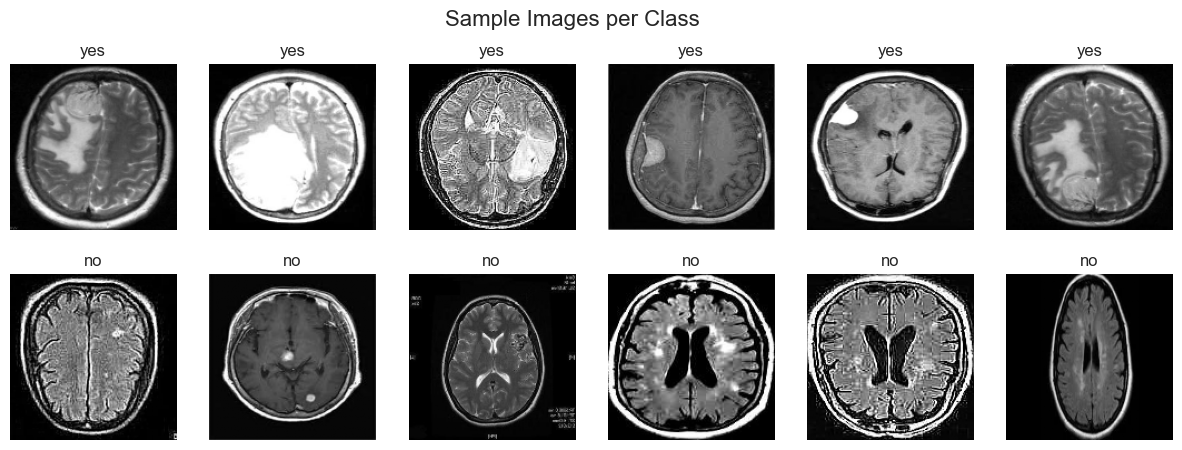

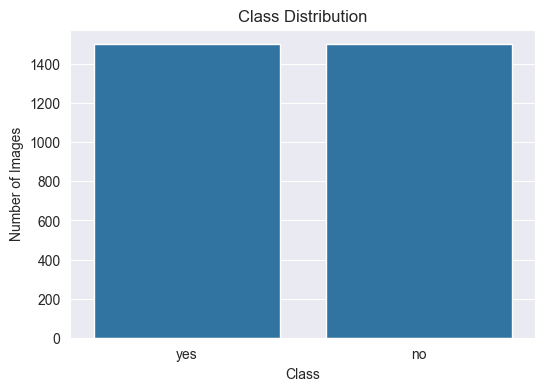

In [25]:
 # step 5: Data visualization

def visualize_samples(data, labels, categories, samples_per_class=6):
    plt.figure(figsize=(15,5))
    for idx, category in enumerate(categories):
        cat_indices = np.where(labels == category)[0]
        cat_indices = np.random.choice(cat_indices, samples_per_class, replace=False)
        for i, img_idx in enumerate(cat_indices):
            plt.subplot(len(categories), samples_per_class, idx*samples_per_class + i + 1)
            plt.imshow(data[img_idx], cmap='gray')
            plt.title(category)
            plt.axis('off')
    plt.suptitle("Sample Images per Class", fontsize=16)
    plt.show()

# Class distribution
def plot_class_distribution(labels, categories):
    labels_series = pd.Series(labels)  # <-- convert to pandas Series
    plt.figure(figsize=(6,4))
    sns.countplot(x=labels_series, order=categories)
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

# Call the functions
visualize_samples(data, labels, categories)
plot_class_distribution(labels, categories)

In [26]:
# step 6 : Prepare labels

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

#step 7:  CNN
if len(data.shape) == 3:  # (num_samples, H, W)
    data_cnn = np.expand_dims(data, axis=-1)
else:
    data_cnn = data  # já tem canal (RGB)

print(data.shape)

(3000, 150, 150)


In [27]:
# step 9: Train / test split

num_samples = data_cnn.shape[0]
indices = np.arange(num_samples)

X_train_idx, X_test_idx, y_train, y_test = train_test_split(
    indices, labels_categorical, test_size=0.2, random_state=42, stratify=labels_encoded
)


def images_to_sequence(img_array, timesteps=32):

    num_samples = img_array.shape[0]
    img_flat = img_array.reshape(num_samples, -1)  # flatten das imagens
    total_features = img_flat.shape[1]
    features = total_features // timesteps
    img_flat_trimmed = img_flat[:, :features*timesteps]  # corta elementos extras
    data_seq = img_flat_trimmed.reshape(num_samples, timesteps, features)
    return data_seq

# CNN
X_train_cnn = data_cnn[X_train_idx]
X_test_cnn  = data_cnn[X_test_idx]

data_seq = images_to_sequence(data_cnn, timesteps=32)
X_train_seq = data_seq[X_train_idx]
X_test_seq  = data_seq[X_test_idx]

print("CNN input shape:", X_train_cnn.shape)
print("Sequence input shape:", X_train_seq.shape)
print("y_train shape:", y_train.shape)


CNN input shape: (2400, 150, 150, 1)
Sequence input shape: (2400, 32, 703)
y_train shape: (2400, 2)


In [28]:
 # step 10: CNN branch

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, concatenate

cnn_input = Input(shape=(150, 150, 1))
x = Conv2D(32, (3,3), activation='relu')(cnn_input)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
cnn_output = Dense(128, activation='relu')(x)

In [29]:
# step 11 LSTM Branch

seq_input = Input(shape=(32, 703))
y = LSTM(128, return_sequences=False)(seq_input)
y = Dense(64, activation='relu')(y)
lstm_output = Dense(32, activation='relu')(y)


In [30]:
# Concatenate CNN + LSTM
combined = concatenate([cnn_output, lstm_output])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
output = Dense(2, activation='softmax')(z)  # 2 classes

#  Model
model = Model(inputs=[cnn_input, seq_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

# train model

history = model.fit(
    [X_train_cnn, X_train_seq],
    y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 148, 148,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 74, 74,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 72, 72,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32, 703)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 36, 36,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    425,984 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 82944)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 10,616,960 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 160)       │          0 │ dense[0][0],      │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │     10,304 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │        130 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,082,530 (42.28 MB)

 Trainable params: 11,082,530 (42.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 293ms/step - accuracy: 0.6958 - loss: 26.7515 - val_accuracy: 0.8313 - val_loss: 0.4090
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - accuracy: 0.8620 - loss: 0.3665 - val_accuracy: 0.9167 - val_loss: 0.2288
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 281ms/step - accuracy: 0.9375 - loss: 0.1837 - val_accuracy: 0.9396 - val_loss: 0.1564
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 276ms/step - accuracy: 0.9464 - loss: 0.1410 - val_accuracy: 0.9563 - val_loss: 0.1372
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 278ms/step - accuracy: 0.9781 - loss: 0.0607 - val_accuracy: 0.9646 - val_loss: 0.1748
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 287ms/step - accuracy: 0.9797 - loss: 0.0639 - val_accuracy: 0.9542 - val_loss: 0.1960
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - accuracy: 0.9875 - loss: 0.0360 - val_accuracy: 0.9688 - val_loss: 0.1390
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 277ms/step - accuracy: 0.9964 - loss: 0.0165 - val_acc

In [33]:
# Step 12 : Accuracy and analysis test

from sklearn.metrics import classification_report, confusion_matrix

# Evalueta on the test
test_loss, test_acc = model.evaluate([X_test_cnn, X_test_seq], y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Predictions and report

y_pred = model.predict([X_test_cnn, X_test_seq])
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

# confusion Matrix

cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

Test Accuracy: 0.9467
Test Loss: 0.4474
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       300
           1       0.94      0.95      0.95       300

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600

Confusion Matrix:
[[282  18]
 [ 14 286]]


Confusion Matrix:
[[282  18]
 [ 14 286]]

282 and 289 are correctly classified samples
18 + 14 = 32 misclassified samples out of 600 --> ~5% error


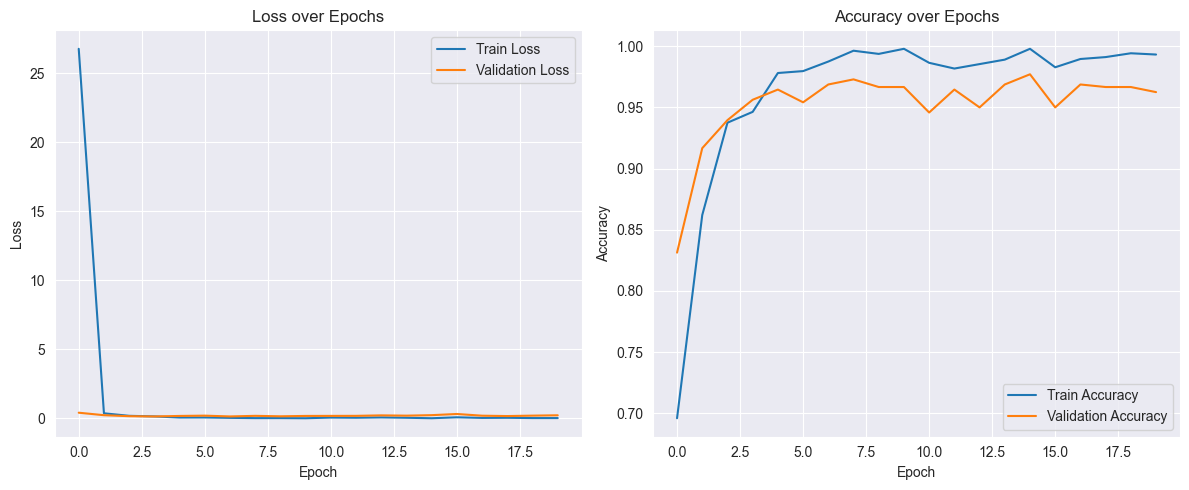

In [34]:
 # Step 13:

#trainig curves

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()